importing necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
rcParams['figure.figsize']=20,10




read the dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/famili.csv")
df.head()
df.index
df = df.rename(columns={'<DTYYYYMMDD>': 'Date', '<CLOSE>':'Close'})

modify the data index

In [3]:

df["Date"] = pd.to_datetime(df.Date, format="%Y%m%d")
df.index = df['Date']
df.index


DatetimeIndex(['2021-07-18', '2021-07-17', '2021-07-14', '2021-07-13',
               '2021-07-12', '2021-07-11', '2021-07-10', '2021-07-07',
               '2021-07-06', '2021-07-05',
               ...
               '2007-02-18', '2007-02-17', '2007-02-14', '2007-02-13',
               '2007-02-12', '2007-02-10', '2007-02-07', '2007-02-06',
               '2007-02-05', '2007-02-04'],
              dtype='datetime64[ns]', name='Date', length=3191, freq=None)

plot the data to have a better perception from the data

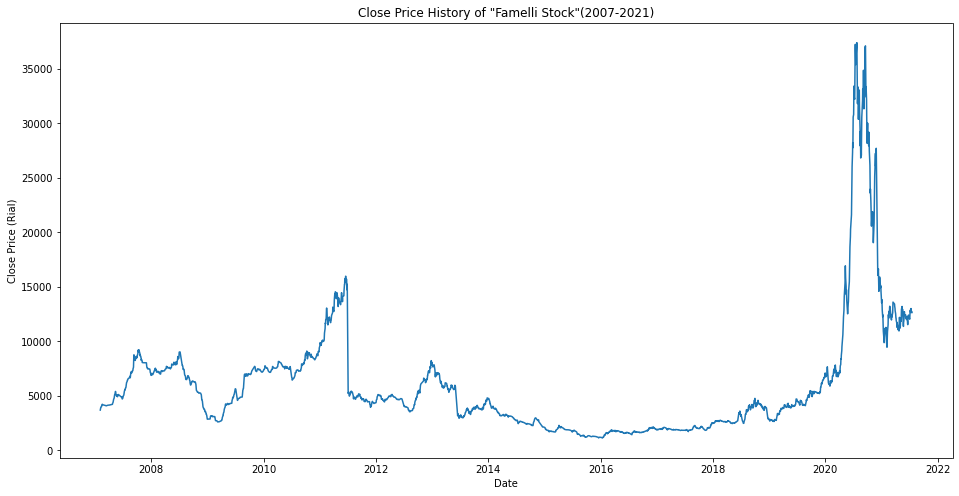

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of "Famelli Stock"(2007-2021)')
plt.plot(df["Close"],label='Close Price history')
plt.xlabel('Date')
plt.ylabel('Close Price (Rial)')
plt.show()

the important columns of  our data, are the 'Data' and 'Close' columns so we will extract these two columns from  the dataframe.now we have a new dataframe with two columns called 'new_dataset'.  notice the 'close' column is our important column for training .

In [5]:
data = df.sort_index(ascending = True,axis = 0)
new_dataset = pd.DataFrame(index = range(0,len(df)),columns = ['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i] = data['Date'][i]
    new_dataset["Close"][i] = data["Close"][i]
new_dataset1 = new_dataset

new_dataset.index = new_dataset.Date
new_dataset.drop("Date",axis = 1,inplace = True)
new_dataset

,Close
Date,
2007-02-04,3704
2007-02-05,3778
2007-02-06,3853
2007-02-07,3930
2007-02-10,4008
...,...
2021-07-12,13020
2021-07-13,12770
2021-07-14,12670


we will devote the data   to train and test set.then we normalize our data and store it in scaled_data.

In [6]:
final_dataset = new_dataset.values

train_data = final_dataset[0:1200,:]
test_data = final_dataset[1200:,:]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)
print('Normalize Price:\n',scaled_data)

Normalize Price:
 [[0.07071765]
 [0.07275785]
 [0.07482562]
 ...
 [0.31791238]
 [0.320118  ]
 [0.31736098]]


we have to split train data into  the x_train_data and y_train_data. we append  our past 60 values to our x_train_data and the 61th value to y_train_data. the y_train_data contains our target value. 

In [7]:
x_train_data,y_train_data = [],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data, y_train_data = np.array(x_train_data),np.array(y_train_data)

x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
print("dimension of x_train is:",x_train_data.shape)
print("dimension of y_train is:",y_train_data.shape)

dimension of x_train is: (1140, 60, 1)
dimension of y_train is: (1140,)


Define LSTM Neural Network . we will add dropout to avoid overfitting

In [8]:

lstm_model = Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1))
lstm_model.summary()





Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


train the network

In [9]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=7,batch_size=1,verbose=2)


Epoch 1/7
1140/1140 - 31s - loss: 0.0020
Epoch 2/7
1140/1140 - 28s - loss: 7.5798e-04
Epoch 3/7
1140/1140 - 28s - loss: 5.6614e-04
Epoch 4/7
1140/1140 - 28s - loss: 6.0915e-04
Epoch 5/7
1140/1140 - 28s - loss: 5.6410e-04
Epoch 6/7
1140/1140 - 28s - loss: 4.5798e-04
Epoch 7/7
1140/1140 - 28s - loss: 4.1080e-04


In [10]:
inputs_data = new_dataset[len(new_dataset)-len(test_data)-60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)
inputs_data.shape


(2051, 1)

we will make our test data for prediction with the same logic that we use for making our training data

In [11]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))


the test data is ready so we can make predictions using lstm

In [12]:
closing_price = lstm_model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

lstm_model.save("Stock_lstm_model.h5")

we add the prediction values to the real values in one data frame.

In [13]:
train = new_dataset[1200:]
test = new_dataset1[1200:]
test['predictions']= closing_price
test



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close,predictions
Date,,
2012-09-08,4230,3738.068115
2012-09-09,4187,3854.419678
2012-09-10,4278,3931.041260
2012-09-11,4444,3997.802246
2012-09-15,4619,4092.909668
...,...,...
2021-07-12,13020,12805.616211
2021-07-13,12770,12915.331055
2021-07-14,12670,12896.294922


now is the time for visualizing the data and see the performance of our model on the test data. 

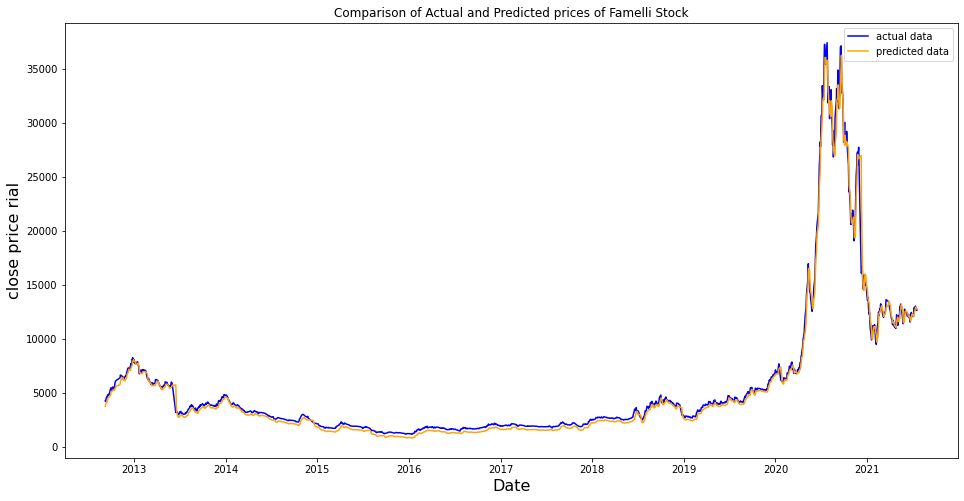

Famelli Stock Will be Negative in tomorrow: -1


In [14]:
plt.figure(figsize=(16,8))
plt.title('model')
plt.xlabel('Date',fontsize=16)
plt.ylabel('close price rial',fontsize=16)
plt.title('Comparison of Actual and Predicted prices of Famelli Stock')
plt.plot(test['Close'],color = 'blue',label = 'actual data')
plt.plot(test['predictions'],color = 'orange',label = 'predicted data')
plt.legend()
plt.show()
Predicted_tomorrow = closing_price[len(closing_price)-1] - closing_price[len(closing_price)-2]
if (Predicted_tomorrow> 0):
    print('Famelli Stock Will be positive in tomorrow:','1')
else:
    print('Famelli Stock Will be Negative in tomorrow:','-1')

exit()